In [1]:
from pymo.parsers import BVHParser
from pymo.viz_tools import *
from pymo.preprocessing import *
from sklearn.pipeline import Pipeline
import pickle
import glob
import os
from tqdm import tqdm
from pathlib import Path

In [2]:
parser = BVHParser()
parsed_data = parser.parse('/datasets/extra_space2/ostap/kinematic-dataset-of-actors-expressing-emotions-2.1.0/BVH/F01/F01A0V1.bvh')

In [74]:
data_pipe = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
#     ('np', Numpyfier()),
#     ('stdscale', ListStandardScaler())
])

In [75]:
piped_data = data_pipe.fit_transform([parsed_data])

/home/ostap/university/kinematic_emotions/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [89]:
def get_adjacency_matrix(mocap_data, num_channels=3):
    nodes_num = mocap_data.values.shape[1] // num_channels    
    # assign nodes numbers
    used_nodes = {}
    for i, name in enumerate(mocap_data.values.columns):
        node_name = '_'.join(name.split('_')[:-1])
        if node_name not in used_nodes:
            used_nodes[node_name] = i // num_channels
        else:
            assert used_nodes[node_name] == i // num_channels
    
    # construct adj. matrix
    A = np.zeros((nodes_num, nodes_num))
    for node_name, props in mocap_data.skeleton.items():
        parent = props['parent']
        if parent is None:
            continue
        node_idx, parent_idx = used_nodes[node_name], used_nodes[parent]
        A[node_idx, parent_idx] = 1
        A[parent_idx, node_idx] = 1
        
    return A

In [94]:
A = get_adjacency_matrix(piped_data[0])
A.sum() / 2

71.0

In [76]:
piped_data[0].values

,Head_Nub_Xposition,Head_Nub_Yposition,Head_Nub_Zposition,Head_Xposition,Head_Yposition,Head_Zposition,Hips_Yposition,Hips_dXposition,Hips_dZposition,LeftArm_Xposition,...,Spine1_Zposition,Spine2_Xposition,Spine2_Yposition,Spine2_Zposition,Spine3_Xposition,Spine3_Yposition,Spine3_Zposition,Spine_Xposition,Spine_Yposition,Spine_Zposition
0 days 00:00:00,-1.534540,235.818010,6.733875,-3.627576,219.968372,6.095005,93.643555,0.000000,0.000000,29.158489,...,0.964719,-0.960117,161.927489,2.055277,-1.988040,181.293108,3.410972,0.347733,122.320395,0.120753
0 days 00:00:00.008000,-1.534540,235.818010,6.733875,-3.627576,219.968372,6.095005,93.643555,0.000000,0.000000,29.158489,...,0.964719,-0.960117,161.927489,2.055277,-1.988040,181.293108,3.410972,0.347733,122.320395,0.120753
0 days 00:00:00.016000,-1.534508,235.812277,6.733678,-3.627544,219.962638,6.094808,93.634949,-0.000095,0.000589,29.158521,...,0.964522,-0.960085,161.921756,2.055081,-1.988008,181.287374,3.410775,0.347765,122.314661,0.120557
0 days 00:00:00.024000,-1.529810,235.813331,6.735398,-3.622847,219.963692,6.096528,93.632217,-0.012361,-0.007561,29.163217,...,0.966325,-0.955390,161.922810,2.056800,-1.983312,181.288428,3.412495,0.352290,122.315704,0.122473
0 days 00:00:00.032000,-1.520066,235.813970,6.745531,-3.613102,219.964332,6.106661,93.634018,-0.024455,-0.016993,29.175204,...,0.974666,-0.943259,161.923429,2.065085,-1.971306,181.289221,3.420808,0.364496,122.315950,0.130811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:00:07.288000,-13.442518,233.092012,15.727042,-13.634734,217.160595,14.259721,92.348518,0.062248,0.035937,19.354891,...,6.143310,-3.530326,160.006254,8.486233,-7.087010,179.049734,10.609517,0.938847,120.781355,3.841011
0 days 00:00:07.296000,-13.132603,233.130637,15.989640,-13.324819,217.199221,14.522318,92.364052,0.044297,0.030830,19.722225,...,6.072075,-3.433593,160.033859,8.507128,-6.901227,179.081135,10.738669,0.909738,120.816125,3.742065
0 days 00:00:07.304000,-12.169071,233.378533,15.201660,-12.361325,217.447031,13.735269,92.374954,0.029203,0.031332,20.483328,...,4.489423,-3.196384,160.255953,6.912199,-6.398757,179.312341,9.442242,0.783932,120.978601,2.364534
0 days 00:00:07.312000,-11.900939,233.375968,15.635202,-12.093233,217.444367,14.169893,92.385269,0.019844,0.022776,20.787220,...,4.674513,-3.121749,160.249195,7.169131,-6.250544,179.307472,9.776733,0.756509,120.978423,2.477710


In [77]:
piped_data[0].skeleton

{'Hips': {'parent': None,
  'channels': ['Xposition',
   'Yposition',
   'Zposition',
   'Xrotation',
   'Yrotation',
   'Zrotation'],
  'offsets': [0.0, 93.594, 0.0],
  'children': ['RightUpLeg', 'LeftUpLeg', 'Spine']},
 'RightUpLeg': {'parent': 'Hips',
  'channels': ['Xposition',
   'Yposition',
   'Zposition',
   'Xrotation',
   'Yrotation',
   'Zrotation'],
  'offsets': [-9.5, -1.594, 0.0],
  'children': ['RightLeg']},
 'RightLeg': {'parent': 'RightUpLeg',
  'channels': ['Xposition',
   'Yposition',
   'Zposition',
   'Xrotation',
   'Yrotation',
   'Zrotation'],
  'offsets': [0.0, -42.0, 0.0],
  'children': ['RightFoot']},
 'RightFoot': {'parent': 'RightLeg',
  'channels': ['Xposition',
   'Yposition',
   'Zposition',
   'Xrotation',
   'Yrotation',
   'Zrotation'],
  'offsets': [0.0, -42.0, 0.0],
  'children': ['RightFoot_Nub']},
 'RightFoot_Nub': {'parent': 'RightFoot',
  'channels': [],
  'offsets': [0.0, -8.0, 17.5],
  'children': []},
 'LeftUpLeg': {'parent': 'Hips',
  'chann

In [29]:
bvh_files = glob.glob('/datasets/extra_space2/ostap/kinematic-dataset-of-actors-expressing-emotions-2.1.0/BVH/*/*.bvh')
mp = MocapParameterizer('position')
parser = BVHParser()

for filename in tqdm(bvh_files):
    file_id = filename.split('/')[-1]
    
    parsed_data = parser.parse(filename)    
    piped_data = mp.fit_transform([parsed_data])[0]
    with open(Path('/datasets/extra_space2/ostap/kinematic-dataset-of-actors-expressing-emotions-2.1.0/PyMO_output', file_id), 'wb') as fp:
        pickle.dump(piped_data, fp)

  0%|          | 2/1402 [00:34<6:46:45, 17.43s/it]


KeyboardInterrupt: 

In [12]:
piped_data

<AxesSubplot:>

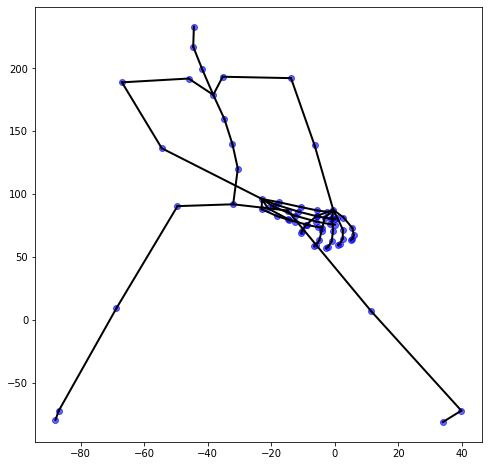

In [6]:
draw_stickfigure(piped_data[0], frame=900)

In [7]:
piped_data = rcpn.fit_transform(piped_data)

/home/ostap/university/kinematic_emotions/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


<AxesSubplot:>

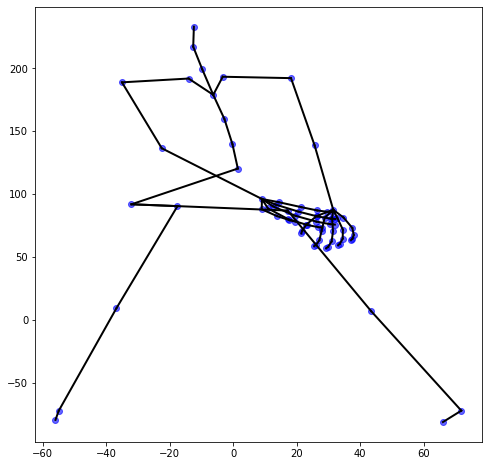

In [8]:
draw_stickfigure(piped_data[0], frame=900)